In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision

In [ ]:
class MultiClassSVM(nn.Module):
    def __init__(self, input_size, num_classes):
        super(MultiClassSVM, self).__init__()
        self.linear = nn.Linear(input_size, num_classes,bias=False)

    def forward(self, x):
        return self.linear(x)
    
def hinge_loss(outputs, labels):
    num_classes = outputs.size(1)
    correct_indices = labels.view(-1, 1)
    correct_scores = outputs.gather(1, correct_indices)
    margins = torch.clamp(1 - (correct_scores - outputs), min=0)
    margins.scatter_(1, correct_indices, 0)
    loss = margins.mean()
    return loss

def train(
    model,
    train_loader,    
    ):
    for batch_idx, (data, target) in enumerate(train_loader):
        output = model(data.float())
        loss = hinge_loss(output, target)
        loss.backward()
        _, argmax = torch.max(output, 1)
        accuracy = (target == argmax.squeeze()).float().mean()
        print("accuracy is",accuracy)


In [ ]:
svm = MultiClassSVM(input_size=28,num_classes=10)

train_loader = torch.utils.data.DataLoader(
    torchvision.datasets.MNIST(
        root=".",
        train=True,
        download=True,
        transform=torchvision.transforms.Compose(
            [
                torchvision.transforms.PILToTensor(),
                
            ]
        ),
        
    ),
    batch_size=64,
    shuffle=True,
    
)
test_loader = torch.utils.data.DataLoader(
    torchvision.datasets.MNIST(
        root=".",
        train=False,
        transform=torchvision.transforms.Compose(
            [
                torchvision.transforms.PILToTensor(),
                
            ]
        ),
    ),
    batch_size=64,
)
train(svm,train_loader)

In [ ]:
import numpy as np
import os
data = np.load('E:/ASU/Norse/w1.npy')
print(data)
print("data shape",data.shape)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
for i in range(data.shape[0]):
    plt.imshow(data[i,0], cmap='Greens', interpolation='nearest')
    plt.colorbar()  # 添加颜色条
    plt.show()


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import os
data1 = np.load('D:/Asu/STAM/Norse/w1_1_4.npy')
data2 = np.load('D:/Asu/STAM/Norse/w1_2_1.npy')
data3 = np.load('D:/Asu/STAM/Norse/w1_3_3.npy')
data4 = np.load('D:/Asu/STAM/Norse/w1_4_5.npy')

x1 = [i for i in range(data1.shape[0])] 
x2 = [i for i in range(data2.shape[0])] 
x3 = [i for i in range(data3.shape[0])] 
x4 = [i for i in range(data4.shape[0])]
plt.plot(x1, data1)
plt.plot(x2, data2)
plt.plot(x3, data3)
plt.plot(x4, data4) 

plt.show()


In [19]:
import torchvision
dataset = torchvision.datasets.Caltech101(
            root="E:/ASU/Norse",
            download=False,
            transform=torchvision.transforms.Compose(
                [
                    torchvision.transforms.PILToTensor(),
                    torchvision.transforms.Resize((240,160)),
                    torchvision.transforms.Grayscale(1)                    
                ]
            ),
        )




i is0 category is Faces
i is1 category is Faces_easy
i is2 category is Leopards
i is3 category is Motorbikes
i is4 category is accordion
i is5 category is airplanes
i is6 category is anchor
i is7 category is ant
i is8 category is barrel
i is9 category is bass
i is10 category is beaver
i is11 category is binocular
i is12 category is bonsai
i is13 category is brain
i is14 category is brontosaurus
i is15 category is buddha
i is16 category is butterfly
i is17 category is camera
i is18 category is cannon
i is19 category is car_side
i is20 category is ceiling_fan
i is21 category is cellphone
i is22 category is chair
i is23 category is chandelier
i is24 category is cougar_body
i is25 category is cougar_face
i is26 category is crab
i is27 category is crayfish
i is28 category is crocodile
i is29 category is crocodile_head
i is30 category is cup
i is31 category is dalmatian
i is32 category is dollar_bill
i is33 category is dolphin
i is34 category is dragonfly
i is35 category is electric_guitar
i

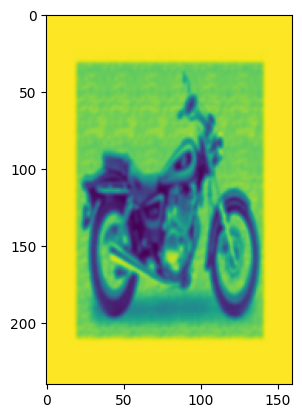

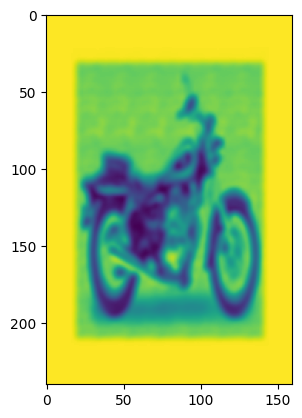

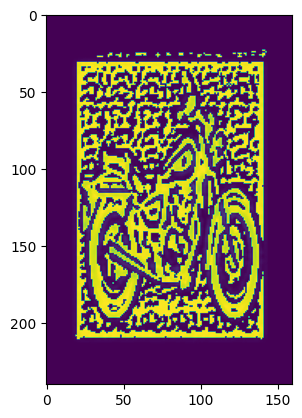

In [35]:
import numpy as np
import matplotlib.pyplot as plt
data1 = np.load("E:/ASU/Norse/DoG filter1.npy")
data2 = np.load("E:/ASU/Norse/DoG filter2.npy")
data3 = np.load("E:/ASU/Norse/DoG filter3.npy")
plt.imshow(data1)
plt.show()
plt.imshow(data2)
plt.show()
plt.imshow(data3)
plt.show()